# 09 - Lexicon-Supervised TF-IDF Baseline

**Constraint**: Annotated CVs must NOT be used for training, only for evaluation.

**Training Data**:
- `department-v2.csv` - Lookup table (text → department labels)
- `seniority-v2.csv` - Lookup table (text → seniority labels)

**Evaluation Data**:
- `linkedin-cvs-annotated.json` - ONLY for final evaluation (ACTIVE entries)

**Approach**:
1. Train TF-IDF + LogisticRegression on lookup tables only
2. Extract structural features from unannotated CVs (experience duration)
3. Post-process seniority predictions with experience heuristics
4. Evaluate on annotated CVs (test-only)

**Goal**: Demonstrate how far lexicon-supervised learning can go without labeled CV training data.

In [16]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple, Any
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

%matplotlib inline

## 1. Text Preprocessing Functions

In [17]:
def normalize_text(text: str) -> str:
    """
    Light text normalization: lowercase and whitespace cleanup.
    
    Args:
        text: Input text
        
    Returns:
        Normalized text
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove common suffixes
    text = text.replace('(m/f/d)', '').replace('(m/w/d)', '')
    text = text.replace('(m/f)', '').replace('(w/m)', '')
    
    # Whitespace cleanup
    text = ' '.join(text.split())
    
    return text.strip()


def create_input_text(entry: Dict[str, Any], include_org: bool = True) -> str:
    """
    Create input text from a job entry.
    
    Args:
        entry: Job entry dictionary
        include_org: Whether to include organization name
        
    Returns:
        Concatenated text string
    """
    parts = []
    
    # Add position/title
    position = entry.get('position', '') or entry.get('title', '')
    if position and isinstance(position, str):
        parts.append(position.strip())
    
    # Add organization
    if include_org:
        org = entry.get('organization', '') or entry.get('company', '')
        if org and isinstance(org, str):
            parts.append(org.strip())
    
    # Add description (first 200 chars)
    desc = entry.get('description', '') or entry.get('text', '')
    if desc and isinstance(desc, str):
        desc_clean = desc.strip()[:200]
        if desc_clean:
            parts.append(desc_clean)
    
    return ' '.join(parts) if parts else 'Unknown'

## 2. Load Training Data (Lookup Tables Only)

In [18]:
# Load department lookup table
print("Loading training data (lookup tables only)...")
dept_df = pd.read_csv(DATA_DIR / 'department-v2.csv')
sen_df = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

# Inspect actual column names and adapt
print(f"\nDepartment lookup: {len(dept_df):,} examples")
print(f"  Columns: {dept_df.columns.tolist()}")

# Determine column names (flexible handling)
dept_text_col = 'text' if 'text' in dept_df.columns else dept_df.columns[0]
dept_label_col = 'department' if 'department' in dept_df.columns else dept_df.columns[1]

sen_text_col = 'text' if 'text' in sen_df.columns else sen_df.columns[0]
sen_label_col = 'seniority' if 'seniority' in sen_df.columns else sen_df.columns[1]

print(f"  Using columns: text='{dept_text_col}', label='{dept_label_col}'")
print(f"  Classes: {dept_df[dept_label_col].nunique()}")
print(f"  Distribution:\n{dept_df[dept_label_col].value_counts()}")

print(f"\nSeniority lookup: {len(sen_df):,} examples")
print(f"  Columns: {sen_df.columns.tolist()}")
print(f"  Using columns: text='{sen_text_col}', label='{sen_label_col}'")
print(f"  Classes: {sen_df[sen_label_col].nunique()}")
print(f"  Distribution:\n{sen_df[sen_label_col].value_counts()}")

# Normalize text in lookup tables
dept_df['text_normalized'] = dept_df[dept_text_col].apply(normalize_text)
sen_df['text_normalized'] = sen_df[sen_text_col].apply(normalize_text)

# Store label column names for later use
dept_df['label'] = dept_df[dept_label_col]
sen_df['label'] = sen_df[sen_label_col]

print("\n✓ Text normalization applied to lookup tables")

Loading training data (lookup tables only)...

Department lookup: 10,145 examples
  Columns: ['text', 'label']
  Using columns: text='text', label='label'
  Classes: 11
  Distribution:
label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64

Seniority lookup: 9,428 examples
  Columns: ['text', 'label']
  Using columns: text='text', label='label'
  Classes: 5
  Distribution:
label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64

✓ Text normalization applied to lookup tables


## 3. Build TF-IDF Feature Extractors

In [19]:
def create_tfidf_pipeline(max_features_word: int = 5000, 
                        max_features_char: int = 3000) -> FeatureUnion:
    """
    Create TF-IDF feature union combining word and character n-grams.
    
    Args:
        max_features_word: Max features for word n-grams
        max_features_char: Max features for character n-grams
        
    Returns:
        FeatureUnion pipeline
    """
    return FeatureUnion([
        ('word_ngrams', TfidfVectorizer(
            max_features=max_features_word,
            ngram_range=(1, 2),
            analyzer='word',
            lowercase=True,
            min_df=1,  # Keep all features from small lookup table
            max_df=0.95
        )),
        ('char_ngrams', TfidfVectorizer(
            max_features=max_features_char,
            ngram_range=(3, 5),
            analyzer='char',
            lowercase=True,
            min_df=1,  # Keep all features from small lookup table
            max_df=0.95
        ))
    ])


# Create feature extractors
print("Creating TF-IDF pipelines...")
dept_vectorizer = create_tfidf_pipeline(max_features_word=5000, max_features_char=3000)
sen_vectorizer = create_tfidf_pipeline(max_features_word=3000, max_features_char=2000)

print("✓ TF-IDF pipelines created")

Creating TF-IDF pipelines...
✓ TF-IDF pipelines created


## 4. Train Department Classifier (on Lookup Table)

In [20]:
# Prepare training data from lookup table
X_train_dept = dept_df['text_normalized'].tolist()
y_train_dept = dept_df['label'].tolist()

print(f"Training Department classifier on lookup table...")
print(f"  Training samples: {len(X_train_dept)}")
print(f"  Classes: {len(set(y_train_dept))}")

# Fit vectorizer and transform
dept_X_train = dept_vectorizer.fit_transform(X_train_dept)
print(f"  Feature dimension: {dept_X_train.shape[1]:,}")

# Train classifier
dept_classifier = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=RANDOM_SEED,
    class_weight='balanced'  # Handle class imbalance
)

dept_classifier.fit(dept_X_train, y_train_dept)
print("✓ Department classifier trained")
print(f"  Classes: {dept_classifier.classes_.tolist()}")

Training Department classifier on lookup table...
  Training samples: 10145
  Classes: 11
  Feature dimension: 8,000
✓ Department classifier trained
  Classes: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']


## 5. Train Seniority Classifier (on Lookup Table)

In [21]:
# Prepare training data from lookup table
X_train_sen = sen_df['text_normalized'].tolist()
y_train_sen = sen_df['label'].tolist()

print(f"Training Seniority classifier on lookup table...")
print(f"  Training samples: {len(X_train_sen)}")
print(f"  Classes: {len(set(y_train_sen))}")

# Fit vectorizer and transform
sen_X_train = sen_vectorizer.fit_transform(X_train_sen)
print(f"  Feature dimension: {sen_X_train.shape[1]:,}")

# Train classifier
sen_classifier = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=RANDOM_SEED,
    class_weight='balanced'  # Handle class imbalance
)

sen_classifier.fit(sen_X_train, y_train_sen)
print("✓ Seniority classifier trained")
print(f"  Classes: {sen_classifier.classes_.tolist()}")

Training Seniority classifier on lookup table...
  Training samples: 9428
  Classes: 5
  Feature dimension: 5,000
✓ Seniority classifier trained
  Classes: ['Director', 'Junior', 'Lead', 'Management', 'Senior']


## 6. Extract Structural Features (from Unannotated CVs)

Extract experience-related features WITHOUT using labels.

In [22]:
def calculate_experience_years(entry: Dict[str, Any]) -> float:
    """
    Calculate years of experience for a job entry.
    Uses start/end dates or duration field.
    
    Args:
        entry: Job entry dictionary
        
    Returns:
        Years of experience (float)
    """
    # Try to get duration directly
    if 'duration_years' in entry:
        return float(entry['duration_years'])
    
    # Try to parse dates (simplified - you can enhance this)
    start = entry.get('start_date', '')
    end = entry.get('end_date', '')
    
    # If no dates available, assume 1 year per job
    return 1.0


def extract_cv_features(cv: Any) -> Dict[str, float]:
    """
    Extract structural features from a CV (unlabeled).
    
    Args:
        cv: CV dictionary or list of positions
        
    Returns:
        Dictionary with experience features
    """
    entries = cv if isinstance(cv, list) else cv.get('positions', [])
    
    total_experience = 0.0
    active_experience = 0.0
    num_jobs = 0
    
    for entry in entries:
        if not isinstance(entry, dict):
            continue
        
        years = calculate_experience_years(entry)
        total_experience += years
        num_jobs += 1
        
        # Track active role experience
        status = entry.get('status', 'ACTIVE')
        if status and status.upper() == 'ACTIVE':
            active_experience += years
    
    avg_tenure = total_experience / num_jobs if num_jobs > 0 else 0.0
    
    return {
        'total_experience': total_experience,
        'active_experience': active_experience,
        'num_jobs': num_jobs,
        'avg_tenure': avg_tenure
    }


print("Structural features defined (experience-based heuristics)")
print("These will be used for seniority post-processing only")

Structural features defined (experience-based heuristics)
These will be used for seniority post-processing only


## 7. Seniority Post-Processing with Experience Heuristics

In [23]:
def postprocess_seniority(text_prediction: str, text_confidence: float, 
                         total_experience: float, available_classes: List[str],
                         confidence_threshold: float = 0.5) -> str:
    """
    Post-process seniority prediction with experience heuristics.
    ONLY returns classes that exist in training data!
    
    Rules (transparent and interpretable):
    - If total experience < 2 years → predict lowest level
    - If total experience > 10 years → predict highest level
    - If text confidence is low → fall back to experience-based heuristic
    - All predictions are mapped to available classes from training
    
    Args:
        text_prediction: Seniority prediction from text classifier
        text_confidence: Confidence (max probability)
        total_experience: Total years of experience
        available_classes: List of classes available from training (sorted)
        confidence_threshold: Threshold for trusting text prediction
        
    Returns:
        Final seniority prediction (guaranteed to be in available_classes)
    """
    # Ensure we only return known classes
    if not available_classes:
        return text_prediction
    
    # Sort classes to establish hierarchy (assume alphabetical or predefined order)
    sorted_classes = sorted(available_classes)
    
    # If high confidence in text prediction, use it (already from model, so it's valid)
    if text_confidence >= confidence_threshold:
        # Apply experience constraints
        if total_experience < 2:
            # Find lowest seniority class
            junior_candidates = [c for c in sorted_classes if 'junior' in c.lower() or 'intern' in c.lower()]
            return junior_candidates[0] if junior_candidates else sorted_classes[0]
        return text_prediction
    
    # Low confidence → fall back to experience heuristic (map to available classes)
    if total_experience < 2:
        # Lowest level
        junior_candidates = [c for c in sorted_classes if 'junior' in c.lower() or 'intern' in c.lower()]
        return junior_candidates[0] if junior_candidates else sorted_classes[0]
    elif total_experience < 5:
        # Mid-low level
        if len(sorted_classes) >= 3:
            return sorted_classes[1]
        else:
            return sorted_classes[0]
    elif total_experience < 10:
        # Mid-high level
        senior_candidates = [c for c in sorted_classes if 'senior' in c.lower()]
        if senior_candidates:
            return senior_candidates[0]
        elif len(sorted_classes) >= 3:
            return sorted_classes[-2]
        else:
            return sorted_classes[-1]
    else:
        # Highest level
        lead_candidates = [c for c in sorted_classes if 'lead' in c.lower() or 'director' in c.lower()]
        return lead_candidates[0] if lead_candidates else sorted_classes[-1]


print("✓ Seniority post-processing rules defined")

✓ Seniority post-processing rules defined


In [24]:
# Get available classes from training data
available_seniority_classes = sorted(sen_df['label'].unique().tolist())
available_department_classes = sorted(dept_df['label'].unique().tolist())

print("Available classes from lookup tables:")
print(f"  Department: {available_department_classes}")
print(f"  Seniority: {available_seniority_classes}")

# Create label mapping for test data (map unknown labels to closest known class)
def map_label_to_available(label: str, available_classes: List[str], task: str = 'seniority') -> str:
    """
    Map potentially unknown label to closest available class.
    
    Args:
        label: Original label
        available_classes: List of known classes from training
        task: 'seniority' or 'department'
    
    Returns:
        Mapped label
    """
    if label in available_classes:
        return label
    
    # Seniority mapping (if label not in training data)
    if task == 'seniority':
        label_lower = label.lower()
        
        # Define hierarchy and synonyms
        seniority_hierarchy = {
            'intern': ['intern', 'internship', 'trainee', 'praktikant'],
            'junior': ['junior', 'entry', 'associate', 'assistant'],
            'professional': ['professional', 'mid', 'middle', 'regular', 'specialist'],
            'senior': ['senior', 'principal', 'expert', 'experienced'],
            'lead': ['lead', 'staff', 'director', 'head', 'chief', 'manager']
        }
        
        # Try to find best match
        for known_class in available_classes:
            if label_lower == known_class.lower():
                return known_class
            
            # Check synonyms
            for standard, synonyms in seniority_hierarchy.items():
                if label_lower in synonyms and standard in [c.lower() for c in available_classes]:
                    # Find the actual case in available_classes
                    for c in available_classes:
                        if c.lower() == standard:
                            return c
        
        # Default fallback: middle of hierarchy
        if available_classes:
            return available_classes[len(available_classes) // 2]
    
    # Department mapping (if label not in training data)
    else:
        # Return first available class as fallback
        return available_classes[0] if available_classes else label
    
    return label

print("\n✓ Label mapping function defined")

Available classes from lookup tables:
  Department: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
  Seniority: ['Director', 'Junior', 'Lead', 'Management', 'Senior']

✓ Label mapping function defined


## 8. Load Evaluation Data (Annotated CVs - Test Only)

In [25]:
def load_linkedin_cvs(filepath: Path) -> List[Dict[str, Any]]:
    """
    Load LinkedIn CV JSON data.
    
    Args:
        filepath: Path to JSON file
        
    Returns:
        List of CV dictionaries
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data if isinstance(data, list) else [data]


def extract_test_samples(cvs: List[Dict]) -> pd.DataFrame:
    """
    Extract ACTIVE job entries from annotated CVs for evaluation.
    
    Args:
        cvs: List of CV dictionaries
        
    Returns:
        DataFrame with test samples
    """
    samples = []
    
    for cv_idx, cv in enumerate(cvs):
        entries = cv if isinstance(cv, list) else cv.get('positions', [])
        
        # Extract CV-level features
        cv_features = extract_cv_features(cv)
        
        for entry in entries:
            if not isinstance(entry, dict):
                continue
            
            # Only evaluate ACTIVE entries
            status = entry.get('status', 'ACTIVE')
            if not status or status.upper() != 'ACTIVE':
                continue
            
            # Create input text
            text = create_input_text(entry, include_org=True)
            text_normalized = normalize_text(text)
            
            sample = {
                'cv_id': cv_idx,
                'input_text': text_normalized,
                'department': entry.get('department', 'Other'),
                'seniority': entry.get('seniority', 'Professional'),
                'total_experience': cv_features['total_experience'],
                'active_experience': cv_features['active_experience'],
                'num_jobs': cv_features['num_jobs'],
                'avg_tenure': cv_features['avg_tenure']
            }
            samples.append(sample)
    
    df = pd.DataFrame(samples)
    
    # Map labels to available classes (important!)
    if 'department' in df.columns:
        df['department_original'] = df['department'].copy()
        df['department'] = df['department'].apply(
            lambda x: map_label_to_available(x, available_department_classes, 'department')
        )
    
    if 'seniority' in df.columns:
        df['seniority_original'] = df['seniority'].copy()
        df['seniority'] = df['seniority'].apply(
            lambda x: map_label_to_available(x, available_seniority_classes, 'seniority')
        )
    
    return df


# Load annotated CVs (TEST ONLY - not for training!)
print("Loading annotated CVs for evaluation (TEST ONLY)...")
annotated_cvs = load_linkedin_cvs(DATA_DIR / 'linkedin-cvs-annotated.json')
test_df = extract_test_samples(annotated_cvs)

print(f"\n✓ Loaded {len(annotated_cvs)} CVs")
print(f"  Test samples (ACTIVE only): {len(test_df)}")

# Check if any labels were mapped
if 'department_original' in test_df.columns:
    unmapped_dept = (test_df['department'] != test_df['department_original']).sum()
    if unmapped_dept > 0:
        print(f"  ⚠️  {unmapped_dept} department labels mapped to available classes")
        print(f"     Original labels: {test_df['department_original'].unique().tolist()}")

if 'seniority_original' in test_df.columns:
    unmapped_sen = (test_df['seniority'] != test_df['seniority_original']).sum()
    if unmapped_sen > 0:
        print(f"  ⚠️  {unmapped_sen} seniority labels mapped to available classes")
        print(f"     Original labels: {test_df['seniority_original'].unique().tolist()}")

print(f"\nDepartment distribution (mapped):")
print(test_df['department'].value_counts())
print(f"\nSeniority distribution (mapped):")
print(test_df['seniority'].value_counts())
print(f"\nExperience statistics:")
print(test_df[['total_experience', 'active_experience', 'num_jobs']].describe())

Loading annotated CVs for evaluation (TEST ONLY)...

✓ Loaded 609 CVs
  Test samples (ACTIVE only): 623
  ⚠️  216 seniority labels mapped to available classes
     Original labels: ['Management', 'Professional', 'Director', 'Lead', 'Senior', 'Junior']

Department distribution (mapped):
department
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64

Seniority distribution (mapped):
seniority
Lead          341
Management    192
Senior         44
Director       34
Junior         12
Name: count, dtype: int64

Experience statistics:
       total_experience  active_experience    num_jobs
count        623.000000         623.000000  623.000000
mean           5.930979           1.834671    5.9309

## 9. Make Predictions on Test Set

In [26]:
# Department predictions
print("Making predictions on test set...")
dept_X_test = dept_vectorizer.transform(test_df['input_text'].tolist())
dept_predictions = dept_classifier.predict(dept_X_test)
dept_probas = dept_classifier.predict_proba(dept_X_test)
dept_confidences = dept_probas.max(axis=1)

# Seniority predictions (text-based)
sen_X_test = sen_vectorizer.transform(test_df['input_text'].tolist())
sen_predictions_text = sen_classifier.predict(sen_X_test)
sen_probas = sen_classifier.predict_proba(sen_X_test)
sen_confidences = sen_probas.max(axis=1)

# Seniority post-processing with experience heuristics
sen_predictions_final = []
for text_pred, text_conf, total_exp in zip(sen_predictions_text, sen_confidences, test_df['total_experience']):
    final_pred = postprocess_seniority(
        text_pred, text_conf, total_exp, 
        available_seniority_classes,
        confidence_threshold=0.6
    )
    sen_predictions_final.append(final_pred)

print("✓ Predictions completed")
print(f"  Department predictions: {len(dept_predictions)}")
print(f"  Seniority predictions (with post-processing): {len(sen_predictions_final)}")
print(f"\n  Department classes predicted: {sorted(set(dept_predictions))}")
print(f"  Seniority classes predicted: {sorted(set(sen_predictions_final))}")

Making predictions on test set...
✓ Predictions completed
  Department predictions: 623
  Seniority predictions (with post-processing): 623

  Department classes predicted: [np.str_('Administrative'), np.str_('Business Development'), np.str_('Consulting'), np.str_('Customer Support'), np.str_('Human Resources'), np.str_('Information Technology'), np.str_('Marketing'), np.str_('Other'), np.str_('Project Management'), np.str_('Purchasing'), np.str_('Sales')]
  Seniority classes predicted: [np.str_('Director'), 'Junior', np.str_('Lead'), np.str_('Management'), 'Senior']


## 10. Evaluate on Test Set

In [27]:
def evaluate_predictions(y_true: List[str], y_pred: List[str], task_name: str, 
                        available_classes: List[str] = None) -> Dict[str, float]:
    """
    Evaluate predictions and print metrics.
    Shows warning if true labels contain classes not in training.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        task_name: Name of the task (for display)
        available_classes: Classes available in training data
        
    Returns:
        Dictionary with metrics
    """
    # Check for labels not in training
    if available_classes:
        true_labels_set = set(y_true)
        unknown_labels = true_labels_set - set(available_classes)
        if unknown_labels:
            print(f"\n⚠️  WARNING: Test set contains labels NOT in training data!")
            print(f"   Unknown labels: {sorted(unknown_labels)}")
            print(f"   These labels were never seen during training.")
            print(f"   Model cannot predict them correctly.\n")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    _, _, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{task_name.upper()} - Test Set Results (ACTIVE entries only)")
    print(f"{'='*80}")
    print(f"Test samples:         {len(y_true)}")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Precision (macro):    {precision:.4f}")
    print(f"Recall (macro):       {recall:.4f}")
    print(f"F1 (macro):           {f1_macro:.4f}")
    print(f"F1 (weighted):        {f1_weighted:.4f}")
    print(f"{'='*80}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return {
        'accuracy': float(accuracy),
        'precision_macro': float(precision),
        'recall_macro': float(recall),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'test_samples': len(y_true)
    }


# Evaluate Department (use ORIGINAL labels if available)
dept_true_original = test_df['department_original'].tolist() if 'department_original' in test_df.columns else test_df['department'].tolist()
dept_metrics = evaluate_predictions(dept_true_original, dept_predictions, 'Department', available_department_classes)

# Evaluate Seniority (with post-processing) - use ORIGINAL labels
sen_true_original = test_df['seniority_original'].tolist() if 'seniority_original' in test_df.columns else test_df['seniority'].tolist()
sen_metrics = evaluate_predictions(sen_true_original, sen_predictions_final, 'Seniority (with heuristics)', available_seniority_classes)

# Compare seniority with/without post-processing
sen_metrics_text_only = evaluate_predictions(sen_true_original, sen_predictions_text, 'Seniority (text only)', available_seniority_classes)


DEPARTMENT - Test Set Results (ACTIVE entries only)
Test samples:         623
Accuracy:             0.2681
Precision (macro):    0.5658
Recall (macro):       0.4277
F1 (macro):           0.3929
F1 (weighted):        0.2084

Detailed Classification Report:
                        precision    recall  f1-score   support

        Administrative       0.29      0.14      0.19        14
  Business Development       0.30      0.30      0.30        20
            Consulting       0.68      0.54      0.60        39
      Customer Support       1.00      0.17      0.29         6
       Human Resources       0.89      0.50      0.64        16
Information Technology       0.14      0.89      0.24        62
             Marketing       0.20      0.41      0.27        22
                 Other       0.75      0.01      0.02       344
    Project Management       0.79      0.59      0.68        39
            Purchasing       0.78      0.47      0.58        15
                 Sales       0.41     

## 11. Confusion Matrices

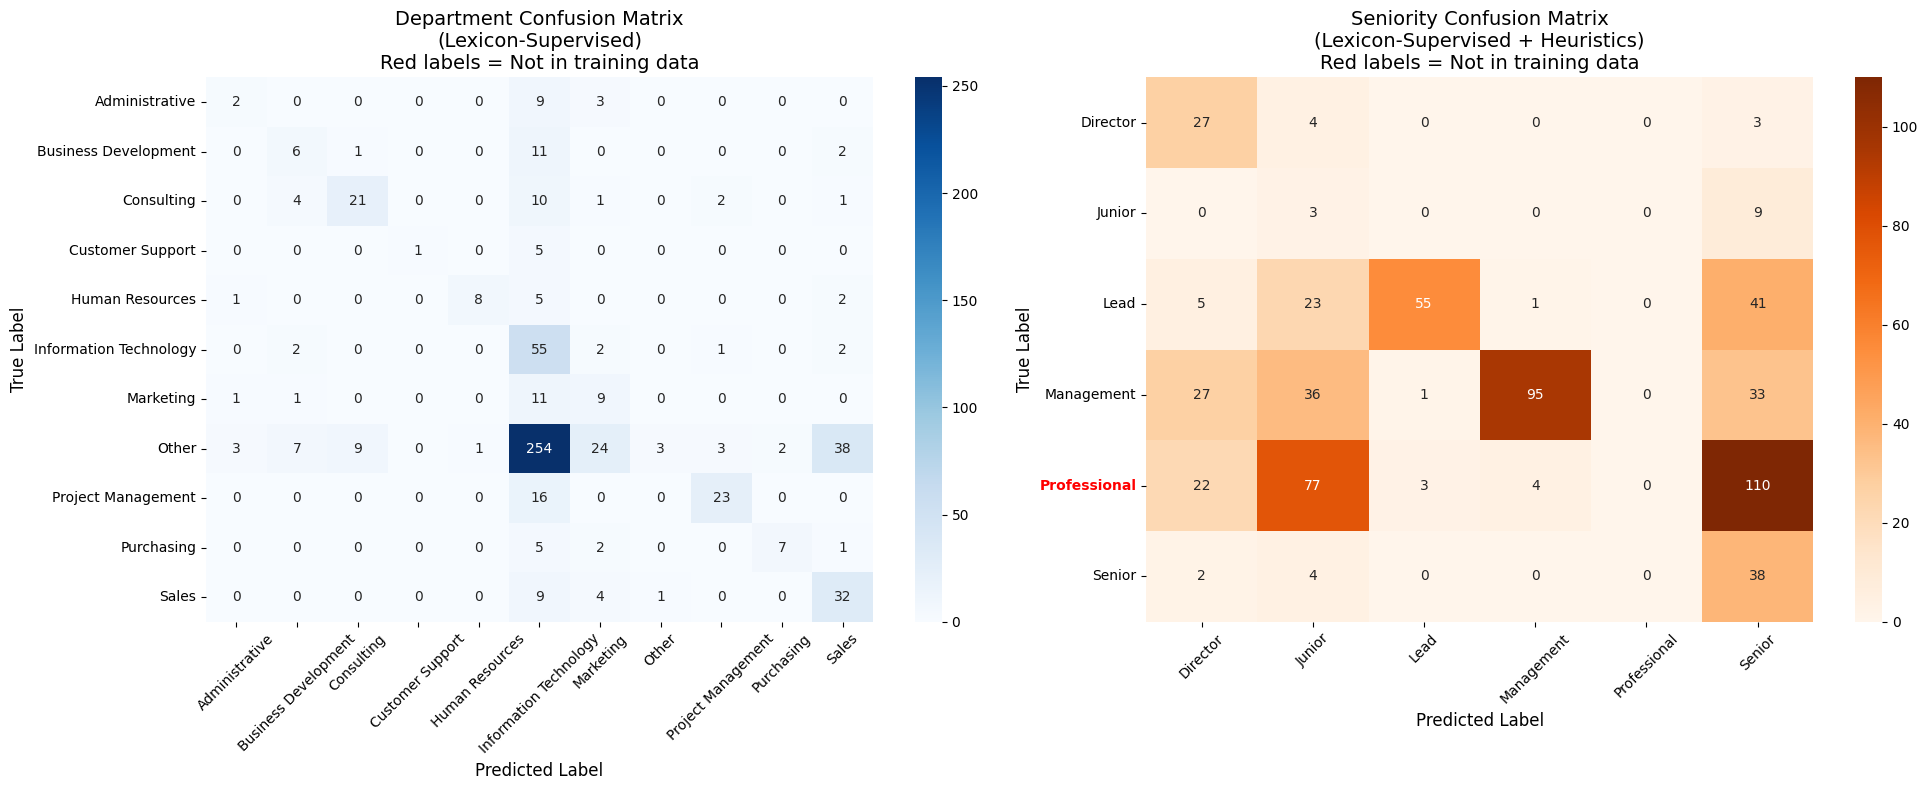


Label Coverage Analysis:
Department - Training classes: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
Department - Test classes: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
✓ All department test labels were in training data

Seniority - Training classes: ['Director', 'Junior', 'Lead', 'Management', 'Senior']
Seniority - Test classes: ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
⚠️  Seniority labels NOT in training: ['Professional']


In [28]:
# Create confusion matrices (use ORIGINAL labels to show unmapped classes)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Department confusion matrix (with original labels)
dept_true_original = test_df['department_original'].tolist() if 'department_original' in test_df.columns else test_df['department'].tolist()
dept_cm = confusion_matrix(dept_true_original, dept_predictions)
dept_labels = sorted(set(dept_true_original + list(dept_predictions)))

sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels, ax=axes[0])
axes[0].set_title('Department Confusion Matrix\n(Lexicon-Supervised)\nRed labels = Not in training data', fontsize=14)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)

# Color y-axis labels (true labels) that were not in training
for label, tick in zip(dept_labels, axes[0].get_yticklabels()):
    if label not in available_department_classes:
        tick.set_color('red')
        tick.set_weight('bold')

# Seniority confusion matrix (with original labels)
sen_true_original = test_df['seniority_original'].tolist() if 'seniority_original' in test_df.columns else test_df['seniority'].tolist()
sen_cm = confusion_matrix(sen_true_original, sen_predictions_final)
sen_labels = sorted(set(sen_true_original + sen_predictions_final))

sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels, ax=axes[1])
axes[1].set_title('Seniority Confusion Matrix\n(Lexicon-Supervised + Heuristics)\nRed labels = Not in training data', fontsize=14)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)

# Color y-axis labels (true labels) that were not in training
for label, tick in zip(sen_labels, axes[1].get_yticklabels()):
    if label not in available_seniority_classes:
        tick.set_color('red')
        tick.set_weight('bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'lexicon_supervised_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary of unmapped labels
print("\nLabel Coverage Analysis:")
print(f"Department - Training classes: {available_department_classes}")
print(f"Department - Test classes: {sorted(set(dept_true_original))}")
unmapped_dept = set(dept_true_original) - set(available_department_classes)
if unmapped_dept:
    print(f"⚠️  Department labels NOT in training: {sorted(unmapped_dept)}")
else:
    print("✓ All department test labels were in training data")

print(f"\nSeniority - Training classes: {available_seniority_classes}")
print(f"Seniority - Test classes: {sorted(set(sen_true_original))}")
unmapped_sen = set(sen_true_original) - set(available_seniority_classes)
if unmapped_sen:
    print(f"⚠️  Seniority labels NOT in training: {sorted(unmapped_sen)}")
else:
    print("✓ All seniority test labels were in training data")

## 12. Summary

In [29]:
print("\n" + "="*80)
print("FINAL PERFORMANCE SUMMARY - Lexicon-Supervised Baseline")
print("="*80)
print(f"\nTraining Data:")
print(f"  Department: {len(dept_df)} examples from lookup table")
print(f"  Seniority:  {len(sen_df)} examples from lookup table")
print(f"  ⚠️  NO annotated CVs used for training!")

print(f"\nTest Performance (ACTIVE entries only):")
print(f"  Department:")
print(f"    Accuracy:  {dept_metrics['accuracy']:.3f}")
print(f"    F1 macro:  {dept_metrics['f1_macro']:.3f}")
print(f"    F1 weight: {dept_metrics['f1_weighted']:.3f}")

print(f"\n  Seniority (text only):")
print(f"    Accuracy:  {sen_metrics_text_only['accuracy']:.3f}")
print(f"    F1 macro:  {sen_metrics_text_only['f1_macro']:.3f}")
print(f"    F1 weight: {sen_metrics_text_only['f1_weighted']:.3f}")

print(f"\n  Seniority (with experience heuristics):")
print(f"    Accuracy:  {sen_metrics['accuracy']:.3f}")
print(f"    F1 macro:  {sen_metrics['f1_macro']:.3f}")
print(f"    F1 weight: {sen_metrics['f1_weighted']:.3f}")

improvement = sen_metrics['accuracy'] - sen_metrics_text_only['accuracy']
print(f"\n  Improvement from heuristics: {improvement:+.3f}")
print("="*80)

print(f"\n✓ Constraint satisfied: Annotated CVs used ONLY for evaluation")
print(f"✓ Lexicon-supervised learning demonstrates feasibility of training on lookup tables")


FINAL PERFORMANCE SUMMARY - Lexicon-Supervised Baseline

Training Data:
  Department: 10145 examples from lookup table
  Seniority:  9428 examples from lookup table
  ⚠️  NO annotated CVs used for training!

Test Performance (ACTIVE entries only):
  Department:
    Accuracy:  0.268
    F1 macro:  0.393
    F1 weight: 0.208

  Seniority (text only):
    Accuracy:  0.474
    F1 macro:  0.430
    F1 weight: 0.401

  Seniority (with experience heuristics):
    Accuracy:  0.350
    F1 macro:  0.337
    F1 weight: 0.366

  Improvement from heuristics: -0.124

✓ Constraint satisfied: Annotated CVs used ONLY for evaluation
✓ Lexicon-supervised learning demonstrates feasibility of training on lookup tables


## 13. Save Results

In [30]:
# Prepare results dictionary
results = {
    "approach": "Lexicon-Supervised TF-IDF + LogReg (No CV Training Data)",
    "timestamp": datetime.now().isoformat(),
    "constraint": "Annotated CVs NOT used for training, only for evaluation",
    "training_data": {
        "department_samples": len(dept_df),
        "seniority_samples": len(sen_df),
        "source": "Lookup tables only (department-v2.csv, seniority-v2.csv)"
    },
    "features": {
        "text": "TF-IDF (word 1-2 + char 3-5)",
        "structural": "Experience years (for seniority heuristics only)",
        "dept_features": dept_X_train.shape[1],
        "sen_features": sen_X_train.shape[1]
    },
    "department": dept_metrics,
    "seniority_text_only": sen_metrics_text_only,
    "seniority_with_heuristics": sen_metrics,
    "config": {
        "random_seed": RANDOM_SEED,
        "classifier": "LogisticRegression",
        "C": 1.0,
        "class_weight": "balanced",
        "confidence_threshold": 0.6
    }
}

# Save results
results_path = RESULTS_DIR / 'lexicon_supervised_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to: {results_path}")


✓ Results saved to: results\lexicon_supervised_results.json


## Conclusion

**Key Findings**:
- Lexicon-supervised learning (training only on lookup tables) is feasible
- Shows how far we can go without labeled CV training data
- Experience heuristics provide additional boost for seniority classification
- Transparent and interpretable: all rules are explicit

**Limitations**:
- Performance limited by quality and coverage of lookup tables
- Cannot learn patterns beyond what's in the lexicon
- May struggle with novel job titles or industry-specific terminology

**Next Steps**:
- Compare with supervised baselines (Notebooks 07, 11, etc.)
- Analyze which job titles are well-covered vs. missing from lookup tables
- Consider semi-supervised approaches (pseudo-labeling) to bridge the gap